## 1.多项式函数拟合实验

### 复杂度和训练数据集大小对欠拟合和过拟合的影响

In [1]:
%matplotlib inline
import gluonbook as gb
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

In [4]:
'''
生成数据集
'''
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape = (n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2),
                         nd.power(features, 3)) # default, axis  = 1
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1] + true_w[2] * poly_features[:, 2] + true_b)
labels += nd.random.normal(scale = 0.1, shape = labels.shape)

In [10]:
features[:3], poly_features[:2], labels[:2]

(
 [[ 0.32510808]
  [-1.3002341 ]
  [ 0.3679345 ]]
 <NDArray 3x1 @cpu(0)>, 
 [[ 0.32510808  0.10569526  0.03436238]
  [-1.3002341   1.6906086  -2.198187  ]]
 <NDArray 2x3 @cpu(0)>, 
 [  5.220803 -14.510632]
 <NDArray 2 @cpu(0)>)

### 定义、训练和测试模型

In [19]:
'''
作图函数
'''
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals = None, y2_vals = None, legend = None, figsize = (3.5, 2.5)):
    gb.set_figsize(figsize)
    gb.plt.xlabel(x_label)
    gb.plt.ylabel(y_label)
    gb.plt.semilogy(x_vals, y_vals) # y轴使用了对数尺度
    if x2_vals and y2_vals:
        gb.plt.semilogy(x2_vals, y2_vals, linestyle = ':')
        gb.plt.legend(legend)

In [20]:
'''
模型定义
'''
num_epochs, loss = 100, gloss.L2Loss()
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle = True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
            range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),
         '\nbias:', net[0].bias.data().asnumpy())

### 三阶多项式函数拟合

final epoch: train loss 0.0077478713 test loss 0.009525575
weight: [[ 1.3188704 -3.3333948  5.5763764]] 
bias: [4.904769]


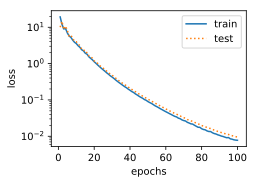

In [22]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
            labels[:n_train], labels[n_train:])

### 线性函数拟合（欠拟合）
#### 线性模型在非线性模型生成的数据集上容易欠拟合

final epoch: train loss 98.72712 test loss 49.401993
weight: [[18.218792]] 
bias: [2.197297]


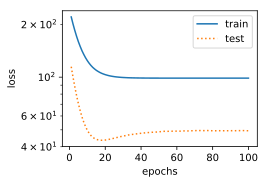

In [24]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

### 训练量不足（过拟合）

final epoch: train loss 3.4001985 test loss 16.00446
weight: [[ 2.6910806 -2.3998957  3.3798702]] 
bias: [0.81079686]


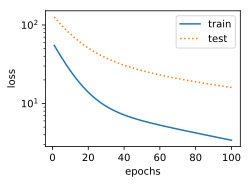

In [25]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[:2], labels[n_train:])